# Training Cats + Dogs Classifier

Source: https://www.kaggle.com/code/uysimty/keras-cnn-dog-or-cat-classification/notebook

In [1]:
# Get the kaggle API
# ! pip install kaggle

To use the Kaggle API, sign up for a Kaggle account at https://www.kaggle.com. Then go to the 'Account' tab of your user profile (https://www.kaggle.com/<username>/account) and select 'Create API Token'. This will trigger the download of kaggle.json, a file containing your API credentials. Place this file in the location ~/.kaggle/kaggle.json 

In [2]:
# Get the dataset -- https://www.kaggle.com/general/6604
# ! kaggle competitions download -c dogs-vs-cats

In [3]:
# Unzip the file
# ! unzip input/dogs-vs-cats.zip
# ! unzip input/train/train.zip

In [4]:
# install and import libraries
import numpy as np
import pandas as pd 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [5]:
# Import Library

import random
import os
print(os.listdir("input/"))

['sampleSubmission.csv', 'train', 'test1', '.ipynb_checkpoints', 'test-cat-dog-model.ipynb']


In [6]:
# check version numbers. these need to be same as in requirements.txt
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)

2.7.0
2.7.0


In [7]:
# Define Constants
FAST_RUN = True
IMAGE_WIDTH=64
IMAGE_HEIGHT=64
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [8]:
# Prepare Traning Data
filenames = os.listdir("input/train")
filenames[:10]

['cat.0.jpg',
 'cat.1.jpg',
 'cat.10.jpg',
 'cat.100.jpg',
 'cat.1000.jpg',
 'cat.10000.jpg',
 'cat.10001.jpg',
 'cat.10002.jpg',
 'cat.10003.jpg',
 'cat.10004.jpg']

In [9]:
# make dataframe
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [10]:
# view
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


<AxesSubplot:>

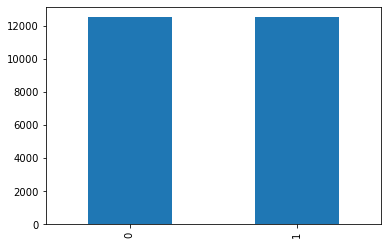

In [11]:
# See Total In count
df['category'].value_counts().plot.bar()

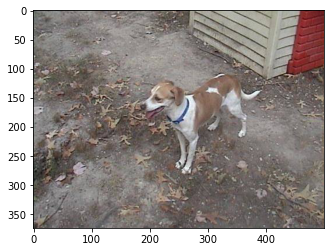

In [12]:
# See sample image
sample = random.choice(filenames)
image = load_img("input/train/"+sample)
plt.imshow(image)

In [13]:
# Build model

<img src='notebook-images/model_shape.jpeg' width="800" height="400">

- Input Layer: It represent input image data. It will reshape image into single diminsion array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.
- Conv Layer: This layer will extract features from image.
- Pooling Layer: This layerreduce the spatial volume of input image after convolution.
- Fully Connected Layer: It connect the network from a layer to another layer
- Output Layer: It is the predicted values layer.

In [14]:
# imports
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

In [15]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

In [16]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 29, 29, 64)       2

## Callbacks

In [17]:
# Callbacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [18]:
# Early Stopping
# To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased
earlystop = EarlyStopping(patience=10)

In [19]:
# Learning Rate Reduction
# We will reduce the learning rate when then accuracy not increase for 2 steps
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [20]:
callbacks = [earlystop, learning_rate_reduction]

## Prepare Data

Because we will use image genaretor with class_mode="categorical". We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification.

So we will convert 1 to dog and 0 to cat

In [21]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [22]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot:>

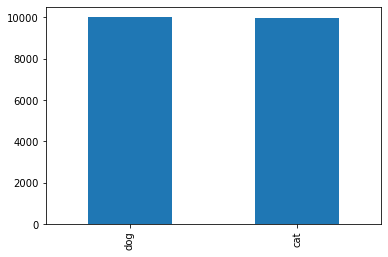

In [23]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

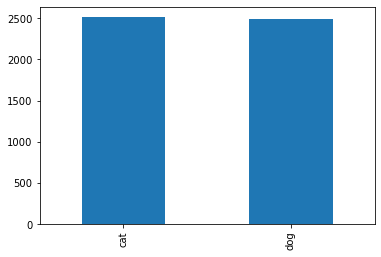

In [24]:
validate_df['category'].value_counts().plot.bar()

In [25]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

# Training Generator

In [26]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [27]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "input/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


## Validation Generator

In [28]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "input/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


## Test the generator

In [29]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "input/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


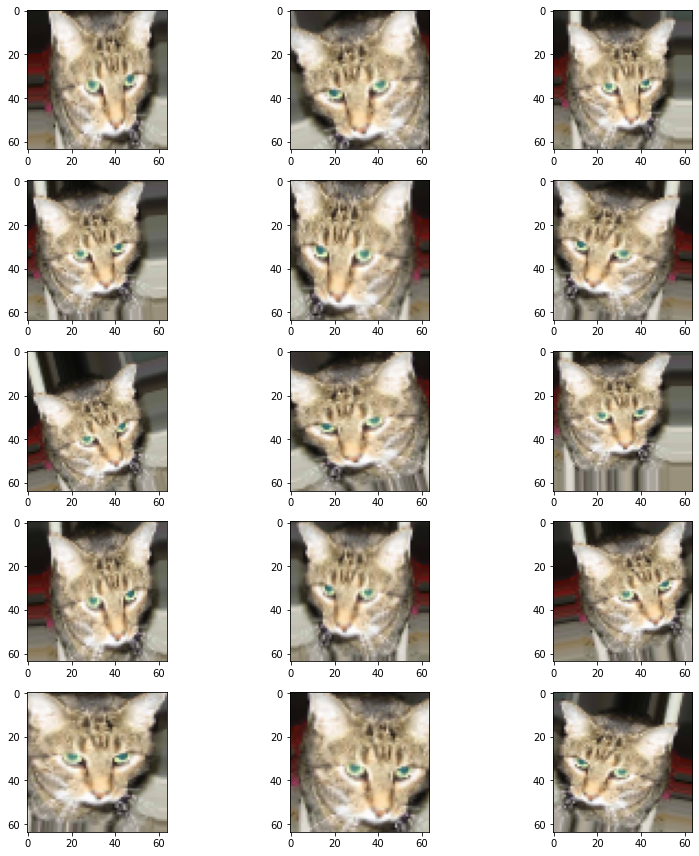

In [30]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Fit Model
The next cell will take a while.

In [31]:
epochs=3 if FAST_RUN else 20
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/3
1333/1333 [==============================] - 135s 100ms/step - loss: 0.7603 - accuracy: 0.6241 - val_loss: 0.6870 - val_accuracy: 0.6456 - lr: 0.0010
Epoch 2/3
1333/1333 [==============================] - 133s 100ms/step - loss: 0.5883 - accuracy: 0.6964 - val_loss: 0.4986 - val_accuracy: 0.7588 - lr: 0.0010
Epoch 3/3
1333/1333 [==============================] - 133s 100ms/step - loss: 0.5402 - accuracy: 0.7318 - val_loss: 0.5142 - val_accuracy: 0.7604 - lr: 0.0010


In [32]:
# Save the model as a folder
model.save("model_outputs/modelrun_3epochsB")

2022-07-11 17:35:04.277677: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model_outputs/modelrun_3epochsB/assets


In [33]:
# Save the model as H5 file
model.save("model_outputs/modelrun_3epochsB.h5")

In [34]:
# Save only the model weights
model.save_weights("model_outputs/modelrun_3epochs_weightsB")

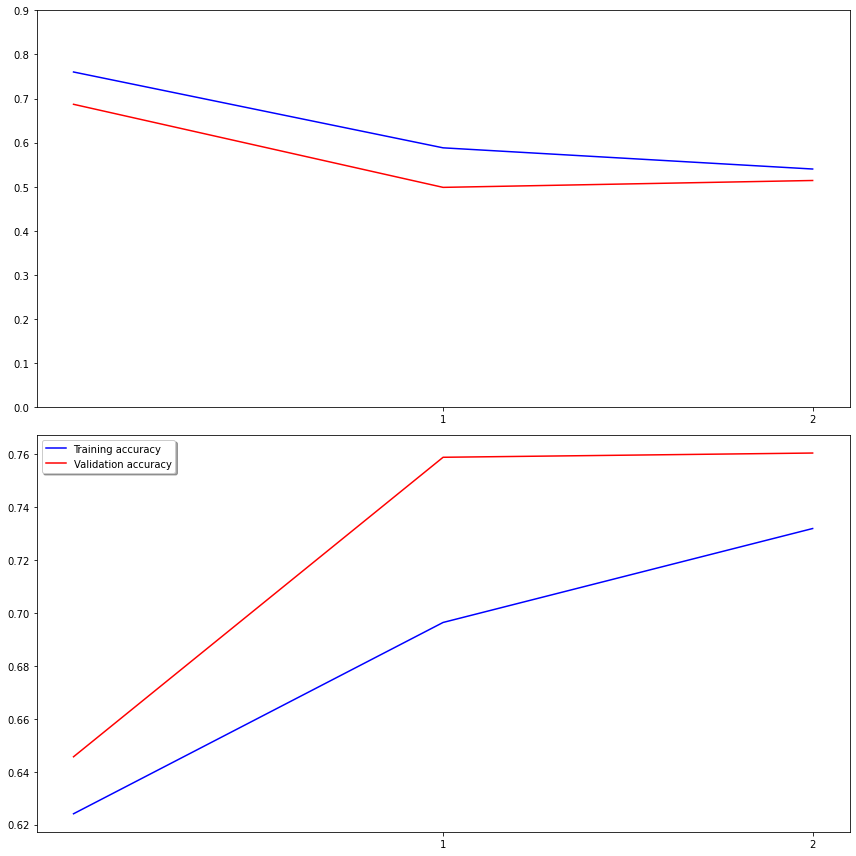

In [35]:
# Visualize Training
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Prepare Testing Data

In [36]:
test_filenames = os.listdir("input/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [37]:
# Create Testing Generator

In [38]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "input/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


# Predict testing data

In [39]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

/tmp/ipykernel_1563/3090721588.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


For categoral classication the prediction will come with probability of each category. So we will pick the category that have the highest probability with numpy average max

In [40]:
test_df['category'] = np.argmax(predict, axis=-1)

We will convert the predict category back into our generator classes by using train_generator.class_indices. It is the classes that image generator map while converting data into computer vision

In [41]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

From our prepare data part. We map data with {1: 'dog', 0: 'cat'}. Now we will map the result back to dog is 1 and cat is 0

In [42]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

# Visualize results

<AxesSubplot:>

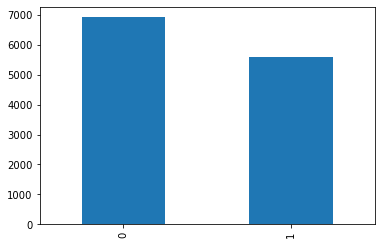

In [43]:
test_df['category'].value_counts().plot.bar()

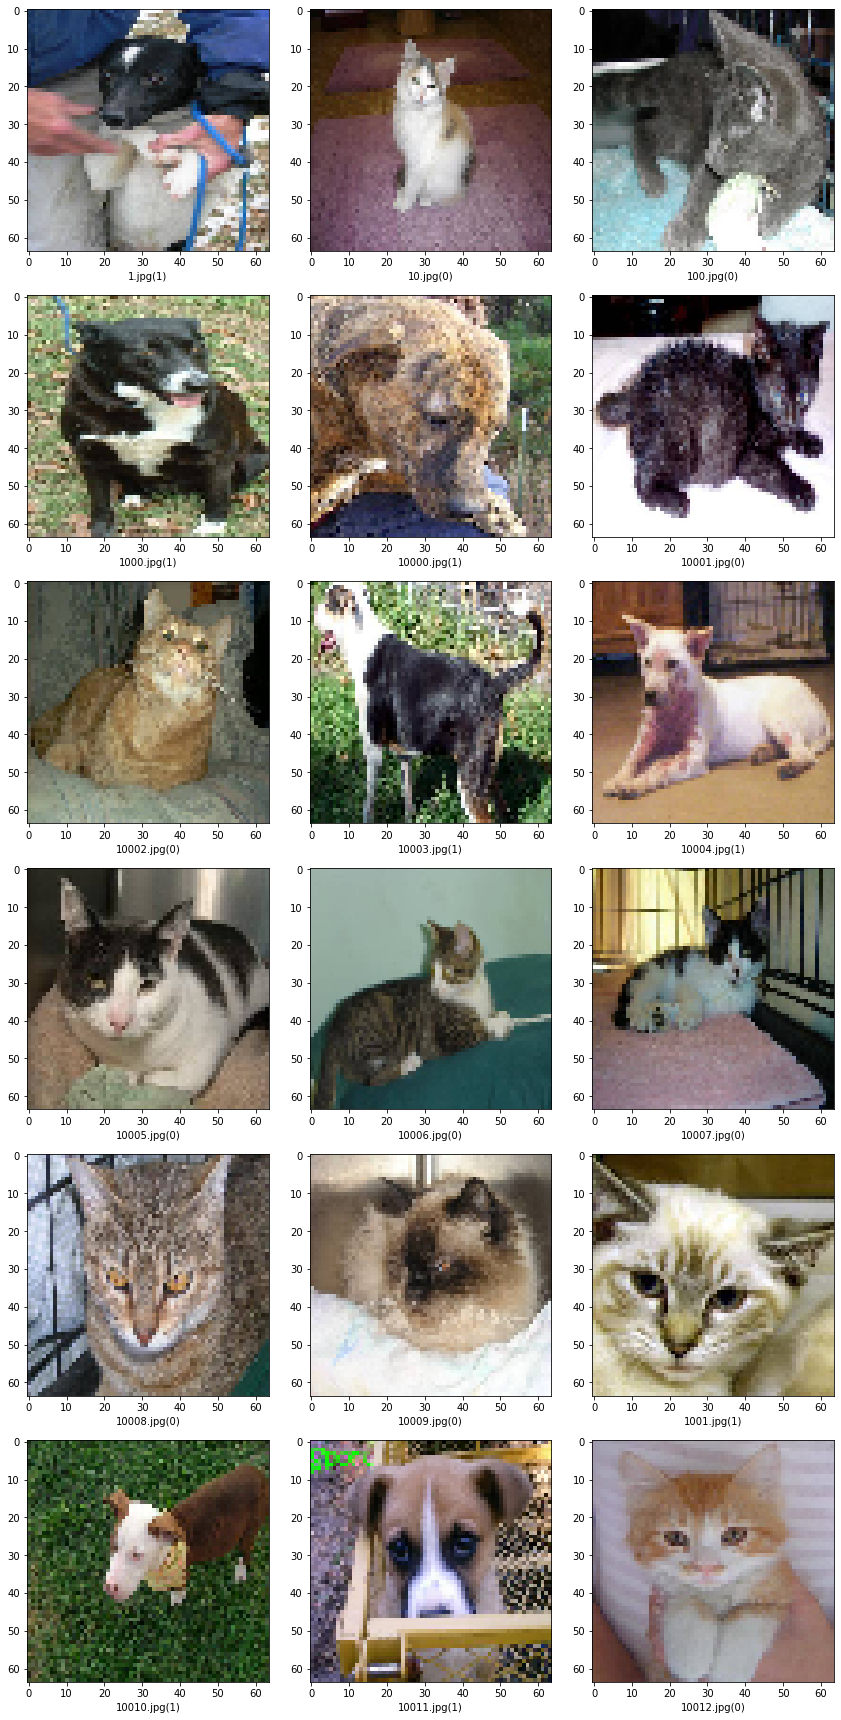

In [44]:
# See predicted result with images
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("input/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [45]:
# Prepare submission
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('model_outputs/submission.csv', index=False)

In [46]:
# reload the model
from tensorflow.keras.models import load_model
model = load_model('model_outputs/modelrun_3epochs')

In [47]:
tf.__version__

'2.7.0'